# 1. Imports

In [1]:
import pandas as pd
import numpy as np

# TESTING
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from numpy import mean
from numpy import std
import statistics
import scipy.stats as stats

# TRAINING
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# SAVING
import pickle

# MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

# 2. Importing the Ranking Files

In [22]:
portmap_ranking = pd.read_csv("../final_ranking/CSE_CIC_IDS2018/ddos_portmap_2018.csv", index_col=0)
syn_ranking = pd.read_csv("../final_ranking/CIC_DDoS2019/ddos_syn_2019.csv", index_col=0)
udp_ranking = pd.read_csv("../final_ranking/CIC_DDoS2019/ddos_udp_2019.csv", index_col=0)
netbios_ranking = pd.read_csv("../final_ranking/CIC_DDoS2019/ddos_netbios_2019.csv", index_col=0)
ldap_ranking = pd.read_csv("../final_ranking/CIC_DDoS2019/ddos_ldap_2019.csv", index_col=0)

# 3. Importing the Training Datasets

In [23]:
portmap_train = pd.read_csv("../data/train_test/CSE_CIC_IDS2018/ddos_portmap_2018_train.csv", index_col=0)
ldap_train = pd.read_csv("../data/train_test/CIC_DDoS2019/ddos_ldap_2019_train.csv", index_col=0)
netbios_train = pd.read_csv("../data/train_test/CIC_DDoS2019/ddos_netbios_2019_train.csv", index_col=0)
syn_train = pd.read_csv("../data/train_test/CIC_DDoS2019/ddos_syn_2019_train.csv", index_col=0)
udp_train = pd.read_csv("../data/train_test/CIC_DDoS2019/ddos_udp_2019_train.csv", index_col=0)

In [24]:
portmap_test = pd.read_csv("../data/train_test/CSE_CIC_IDS2018/ddos_portmap_2018_test.csv", index_col=0)
ldap_test = pd.read_csv("../data/train_test/CIC_DDoS2019/ddos_ldap_2019_test.csv", index_col=0)
netbios_test = pd.read_csv("../data/train_test/CIC_DDoS2019/ddos_netbios_2019_test.csv", index_col=0)
syn_test = pd.read_csv("../data/train_test/CIC_DDoS2019/ddos_syn_2019_test.csv", index_col=0)
udp_test = pd.read_csv("../data/train_test/CIC_DDoS2019/ddos_udp_2019_test.csv", index_col=0)

In [14]:
target_feature = 'Label'

# 3. Training the Model

In [7]:
def trainTestModel(train_df, test_df, master_ranking, baseModel, cv_n, verbose):
    
    if verbose: print("Model: "+str(baseModel))
    
    cv = KFold(n_splits=cv_n, random_state=1, shuffle=True)
    f1_scorer = make_scorer(f1_score, average='weighted')
    
    methods = master_ranking.columns.tolist()[1:-1]
    methods.insert(0, 'AllFeatures')
    methods.append("STEF-Rank_0.1")
    methods.append("STEF-Rank_0.2")
    methods.append("STEF-Rank_0.25")
    methods.append("STEF-Rank_0.3")
    methods.append("STEF-Rank_0.4")
    methods.append("STEF-Rank_0.5")
    methods.append("STEF-Rank_0.6")
    methods.append("STEF-Rank_0.7")
    methods.append("STEF-Rank_0.75")
    methods.append("STEF-Rank_0.8")
    methods.append("STEF-Rank_0.9")
    #if verbose: print(methods)
    
    features = master_ranking['feature'].tolist()
    #if verbose: print(features)
    
    aggregated_data = []
        
    for method in methods:
        print("Training using "+method+"...")
        if verbose: print("_________________________________________________________________________________")
            
        # _____________________________________________________________1. CREATE X BASED ON THE FEATURE SELECTED DURING FEATURE SELECTION
        
        # BASELINES
        if method == 'AllFeatures':
            selected_features = master_ranking['feature'].tolist()
        elif not ("STEF-Rank" in method):
            selected_features = master_ranking[master_ranking[method] == 1]['feature'].tolist()
        # STEF-RANK
        else:
            threshold = method.split("_")[1]
            #print(threshold)
            selected_features = master_ranking[master_ranking['STEF-Rank'] >= float(threshold)]['feature'].tolist()
            
        #if verbose: print(selected_features)
            
        X_train = train_df[selected_features]
        X_test = test_df[selected_features]
        
        y_train = train_df[target_feature].values
        y_test = test_df[target_feature].values
                
        if verbose: print("Training Dataset size: rows =", X_train.shape[0], ", columns =", X_train.shape[1], "+ 'Label'")
            
        if X_train.shape[1] == 0:
            
            temp = {'method':method,'mean_cv_f1':'nan','test_f1':'nan','auc_pr':'nan'}
            
        else:

            # _____________________________________________________________2. TRAIN THE MODEL USING CV (K=5)
            model = baseModel()
            model.fit(X_train, y_train)
            f1s = cross_val_score(model, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1)

            if verbose: print('CV F1-Score Mean (std): %.3f (%.3f)' % (mean(f1s), std(f1s)))

            if verbose: print("Testing Dataset size: rows =", X_test.shape[0], ", columns =", X_test.shape[1], "+ 'Label'")

            if verbose: print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
            # _____________________________________________________________3. EVALUATE THE MODEL
            y_preds = model.predict(X_test)
            test_f1 = f1_score(y_test, y_preds)

            y_pred_prob = model.predict_proba(X_test)
            y_pred_prob = y_pred_prob[:, 1]
            precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
            auc_pr = auc(recall, precision)

            if verbose: print("Test F1-Scrore "+str(test_f1))
            if verbose: print("Test AUC-PR "+str(auc_pr))

            # _____________________________________________________________4. SAVE THE MODEL RESULTS

            temp = {'method':method,'num_features':len(selected_features),'mean_cv_f1':mean(f1s),'test_f1':test_f1,'auc_pr':auc_pr}
        
        aggregated_data.append(temp)
        
        results_df = pd.DataFrame(aggregated_data)
        
    return results_df
        
        

In [35]:
portmap_performance = trainTestModel(portmap_train, portmap_test, portmap_ranking, LogisticRegression, 10, verbose=False)
portmap_performance

Training using AllFeatures...
Training using BackwardElimination...
Training using MutualInformation...
Training using RFE...
Training using SelectKBest...
Training using VarianceThreshold...
Training using VIF...
Training using STEF-Rank_0.1...
Training using STEF-Rank_0.2...
Training using STEF-Rank_0.25...
Training using STEF-Rank_0.3...
Training using STEF-Rank_0.4...
Training using STEF-Rank_0.5...
Training using STEF-Rank_0.6...
Training using STEF-Rank_0.7...
Training using STEF-Rank_0.75...
Training using STEF-Rank_0.8...
Training using STEF-Rank_0.9...


,method,num_features,mean_cv_f1,test_f1,auc_pr
0,AllFeatures,78,0.988995,0.989853,0.999704
1,BackwardElimination,50,0.986332,0.987441,0.999619
2,MutualInformation,65,0.988518,0.989561,0.999720
3,RFE,50,0.985760,0.987008,0.999460
4,SelectKBest,40,0.985544,0.987199,0.999573
5,VarianceThreshold,36,0.988239,0.989293,0.999690
6,VIF,13,0.965879,0.970487,0.971184
7,STEF-Rank_0.1,73,0.988995,0.989853,0.999704
8,STEF-Rank_0.2,69,0.988995,0.989853,0.999704
9,STEF-Rank_0.25,68,0.988995,0.989853,0.999704


In [34]:
udp_performance = trainTestModel(udp_train, udp_test, udp_ranking, LogisticRegression, 10, verbose=False)
udp_performance

Training using AllFeatures...
Training using BackwardElimination...
Training using MutualInformation...
Training using RFE...
Training using SelectKBest...
Training using VarianceThreshold...
Training using VIF...
Training using STEF-Rank_0.1...
Training using STEF-Rank_0.2...
Training using STEF-Rank_0.25...
Training using STEF-Rank_0.3...
Training using STEF-Rank_0.4...
Training using STEF-Rank_0.5...
Training using STEF-Rank_0.6...
Training using STEF-Rank_0.7...
Training using STEF-Rank_0.75...
Training using STEF-Rank_0.8...
Training using STEF-Rank_0.9...


,method,num_features,mean_cv_f1,test_f1,auc_pr
0,AllFeatures,85.0,0.998391,0.996143,0.9999
1,BackwardElimination,50.0,0.998391,0.996143,0.99994
2,MutualInformation,59.0,0.998391,0.996143,0.999935
3,RFE,50.0,0.998391,0.993953,0.999948
4,SelectKBest,40.0,0.998621,0.996143,0.999869
5,VarianceThreshold,37.0,0.998391,0.996143,0.999871
6,VIF,20.0,0.997932,0.993953,0.999964
7,STEF-Rank_0.1,73.0,0.998391,0.996143,0.9999
8,STEF-Rank_0.2,73.0,0.998391,0.996143,0.9999
9,STEF-Rank_0.25,72.0,0.998391,0.996143,0.9999


In [36]:
netbios_performance = trainTestModel(netbios_train, netbios_test, netbios_ranking, LogisticRegression, 10, verbose=False)
netbios_performance

Training using AllFeatures...
Training using BackwardElimination...
Training using MutualInformation...
Training using RFE...
Training using SelectKBest...
Training using VarianceThreshold...
Training using VIF...
Training using STEF-Rank_0.1...
Training using STEF-Rank_0.2...
Training using STEF-Rank_0.25...
Training using STEF-Rank_0.3...
Training using STEF-Rank_0.4...
Training using STEF-Rank_0.5...
Training using STEF-Rank_0.6...
Training using STEF-Rank_0.7...
Training using STEF-Rank_0.75...
Training using STEF-Rank_0.8...
Training using STEF-Rank_0.9...


,method,num_features,mean_cv_f1,test_f1,auc_pr
0,AllFeatures,85.0,0.999872,0.999967,1
1,BackwardElimination,50.0,0.999823,0.999958,1
2,MutualInformation,57.0,0.999865,0.999967,1
3,RFE,50.0,0.999625,0.999875,1
4,SelectKBest,40.0,0.999695,0.999908,0.999999
5,VarianceThreshold,7.0,0.998253,0.999275,0.999967
6,VIF,15.0,0.999462,0.999817,0.999965
7,STEF-Rank_0.1,74.0,0.999872,0.999967,1
8,STEF-Rank_0.2,72.0,0.999872,0.999967,1
9,STEF-Rank_0.25,72.0,0.999872,0.999967,1


In [37]:
syn_performance = trainTestModel(syn_train, syn_test, syn_ranking, LogisticRegression, 10, verbose=False)
syn_performance

Training using AllFeatures...
Training using BackwardElimination...
Training using MutualInformation...
Training using RFE...
Training using SelectKBest...
Training using VarianceThreshold...
Training using VIF...
Training using STEF-Rank_0.1...
Training using STEF-Rank_0.2...
Training using STEF-Rank_0.25...
Training using STEF-Rank_0.3...
Training using STEF-Rank_0.4...
Training using STEF-Rank_0.5...
Training using STEF-Rank_0.6...
Training using STEF-Rank_0.7...
Training using STEF-Rank_0.75...
Training using STEF-Rank_0.8...
Training using STEF-Rank_0.9...


,method,num_features,mean_cv_f1,test_f1,auc_pr
0,AllFeatures,85.0,0.999814,0.999867,1
1,BackwardElimination,50.0,0.999712,0.999783,0.999996
2,MutualInformation,45.0,0.999741,0.99985,0.999999
3,RFE,50.0,0.999757,0.999783,1
4,SelectKBest,40.0,0.99967,0.999733,1
5,VarianceThreshold,10.0,0.994814,0.998403,0.999626
6,VIF,17.0,0.999638,0.99975,1
7,STEF-Rank_0.1,82.0,0.999814,0.999867,1
8,STEF-Rank_0.2,74.0,0.999814,0.999867,1
9,STEF-Rank_0.25,71.0,0.999814,0.999867,1


In [38]:
ldap_performance = trainTestModel(ldap_train, ldap_test, ldap_ranking, LogisticRegression, 10, verbose=False)
ldap_performance

Training using AllFeatures...
Training using BackwardElimination...
Training using MutualInformation...
Training using RFE...
Training using SelectKBest...
Training using VarianceThreshold...
Training using VIF...
Training using STEF-Rank_0.1...
Training using STEF-Rank_0.2...
Training using STEF-Rank_0.25...
Training using STEF-Rank_0.3...
Training using STEF-Rank_0.4...
Training using STEF-Rank_0.5...
Training using STEF-Rank_0.6...
Training using STEF-Rank_0.7...
Training using STEF-Rank_0.75...
Training using STEF-Rank_0.8...
Training using STEF-Rank_0.9...


,method,num_features,mean_cv_f1,test_f1,auc_pr
0,AllFeatures,85,0.999944,0.999917,1.000000
1,BackwardElimination,50,0.999923,0.999908,1.000000
2,MutualInformation,47,0.999937,0.999917,1.000000
3,RFE,50,0.999805,0.999833,1.000000
4,SelectKBest,40,0.999833,0.999933,0.999999
5,VarianceThreshold,17,0.999889,0.999917,1.000000
6,VIF,18,0.999228,0.999750,1.000000
7,STEF-Rank_0.1,75,0.999944,0.999917,1.000000
8,STEF-Rank_0.2,73,0.999944,0.999917,1.000000
9,STEF-Rank_0.25,73,0.999944,0.999917,1.000000


In [45]:
# Combine all performance metrics into one dataframe

portmap_performance['dataset'] = 'portmap_2018'
netbios_performance['dataset'] = 'netbios_2019'
syn_performance['dataset'] = 'syn_2019'
ldap_performance['dataset'] = 'ldap_2019'
udp_performance['dataset'] = 'udp_2019'

master_df = pd.concat([portmap_performance, netbios_performance, syn_performance, ldap_performance, udp_performance])

# If you want the new column to be the first column
column_order = ['dataset'] + [col for col in udp_performance.columns if not (col in ['dataset'])]
master_df = master_df[column_order]

In [46]:
master_df.to_csv('../performance/performance.csv')

In [47]:
master_df

,dataset,method,num_features,mean_cv_f1,test_f1,auc_pr
0,portmap_2018,AllFeatures,78.0,0.988995,0.989853,0.999704
1,portmap_2018,BackwardElimination,50.0,0.986332,0.987441,0.999619
2,portmap_2018,MutualInformation,65.0,0.988518,0.989561,0.99972
3,portmap_2018,RFE,50.0,0.98576,0.987008,0.99946
4,portmap_2018,SelectKBest,40.0,0.985544,0.987199,0.999573
...,...,...,...,...,...,...
13,udp_2019,STEF-Rank_0.6,45.0,0.998391,0.996143,0.999956
14,udp_2019,STEF-Rank_0.7,29.0,0.997472,0.996143,0.997996
15,udp_2019,STEF-Rank_0.75,23.0,0.997242,0.996143,0.998888
16,udp_2019,STEF-Rank_0.8,4.0,0.974457,0.969437,0.957183


# 4. Tests for Statistical Significance

In [8]:
def myTTest(new_method, old_method, new_scores, old_scores,measure):

    t_stat, p_value = stats.ttest_rel(old_scores, new_scores)

    print(f'T-statistic: {t_stat}')
    print(f'P-value: {p_value}')

    # Check if the results are significant
    # Typically, if p < 0.05, we reject the null hypothesis
    alpha = 0.05
    if p_value < alpha:
        print('The difference in the mean '+measure+' is statistically significant; '+new_method+' outperforms '+old_method+'.')
    else:
        print('The difference in the mean '+measure+' cannot be proved to be statistically significant; '+new_method+
              ' may not outperform '+old_method+'.')

In [9]:
def myWilcoxon(new_method, old_method, new_scores, old_scores, measure):
    
    stat, p_value = stats.wilcoxon(old_scores, new_scores)

    print(f'Wilcoxon Statistic: {stat}')
    print(f'P-value: {p_value}')

    # Check if the results are significant
    # Typically, if p < 0.05, we reject the null hypothesis
    alpha = 0.05
    if p_value < alpha:
        print('The difference in the median '+measure+' is statistically significant; '+new_method+' outperforms '+old_method+'.')
    else:
        print('The difference in the median '+measure+' cannot be proved to be statistically significant; '+new_method+
              ' may not outperform '+old_method+'.')

In [89]:
baseline_methods = ['AllFeatures','BackwardElimination','MutualInformation','RFE','SelectKBest','VarianceThreshold','VIF']
new_methods = ['STEF-Rank_0.1','STEF-Rank_0.2','STEF-Rank_0.25','STEF-Rank_0.3','STEF-Rank_0.4',
               'STEF-Rank_0.5','STEF-Rank_0.6','STEF-Rank_0.7','STEF-Rank_0.75','STEF-Rank_0.8',
              'STEF-Rank_0.9']

In [91]:
for bm in baseline_methods:
    for nm in new_methods:
        print("____________________________________________________________________________________________")
        
        base_f1s = master_df[master_df['method'] == bm]['test_f1'].tolist()
        new_f1s = master_df[master_df['method'] == nm]['test_f1'].tolist()
        
        base_aucs = master_df[master_df['method'] == bm]['auc_pr'].tolist()
        new_aucs = master_df[master_df['method'] == nm]['auc_pr'].tolist()
        
        base_f1s, new_f1s = zip(*[(x, y) for x, y in zip(base_f1s, new_f1s) if isinstance(x, float) and isinstance(y, float)])
        
        base_aucs, new_aucs = zip(*[(x, y) for x, y in zip(base_aucs, new_aucs) if isinstance(x, float) and isinstance(y, float)])
        
        myTTest(nm,bm,new_f1s,base_f1s,'F1')
        #myWilcoxon(nm,bm,new_f1s,base_f1s,'F1')
        
        myTTest(nm,bm,new_aucs,base_aucs,'AUC-PR')
        #myWilcoxon(nm,bm,new_aucs,base_aucs,'AUC-PR')

____________________________________________________________________________________________
T-statistic: nan
P-value: nan
The difference in the mean F1 cannot be proved to be statistically significant; STEF-Rank_0.1 may not outperform AllFeatures.
T-statistic: -1.0
P-value: 0.373900966300059
The difference in the mean AUC-PR cannot be proved to be statistically significant; STEF-Rank_0.1 may not outperform AllFeatures.
____________________________________________________________________________________________
T-statistic: nan
P-value: nan
The difference in the mean F1 cannot be proved to be statistically significant; STEF-Rank_0.2 may not outperform AllFeatures.
T-statistic: 1.0000000000000002
P-value: 0.3739009663000589
The difference in the mean AUC-PR cannot be proved to be statistically significant; STEF-Rank_0.2 may not outperform AllFeatures.
____________________________________________________________________________________________
T-statistic: nan
P-value: nan
The difference

T-statistic: -1.7512927373305895
P-value: 0.15478233946656736
The difference in the mean F1 cannot be proved to be statistically significant; STEF-Rank_0.2 may not outperform RFE.
T-statistic: -0.7547734283251261
P-value: 0.4923879635464133
The difference in the mean AUC-PR cannot be proved to be statistically significant; STEF-Rank_0.2 may not outperform RFE.
____________________________________________________________________________________________
T-statistic: -1.7512927373305895
P-value: 0.15478233946656736
The difference in the mean F1 cannot be proved to be statistically significant; STEF-Rank_0.25 may not outperform RFE.
T-statistic: -0.7546981232850763
P-value: 0.49242845222674936
The difference in the mean AUC-PR cannot be proved to be statistically significant; STEF-Rank_0.25 may not outperform RFE.
____________________________________________________________________________________________
T-statistic: -1.7512927373305895
P-value: 0.15478233946656736
The difference in the m

T-statistic: 2.030534242487947
P-value: 0.13527430799070275
The difference in the mean F1 cannot be proved to be statistically significant; STEF-Rank_0.8 may not outperform VarianceThreshold.
T-statistic: 1.1493336859304293
P-value: 0.33373771668620433
The difference in the mean AUC-PR cannot be proved to be statistically significant; STEF-Rank_0.8 may not outperform VarianceThreshold.
____________________________________________________________________________________________
T-statistic: 1.0233793387782901
P-value: 0.4926444405512326
The difference in the mean F1 cannot be proved to be statistically significant; STEF-Rank_0.9 may not outperform VarianceThreshold.
T-statistic: 9.524346880886354
P-value: 0.06659730253827928
The difference in the mean AUC-PR cannot be proved to be statistically significant; STEF-Rank_0.9 may not outperform VarianceThreshold.
____________________________________________________________________________________________
T-statistic: -1.1687517858415013
P-va

# 5. Producing Some Graphs

In [4]:
# for different values of the threshold

performance_df = pd.read_csv('../performance/performance.csv', index_col=0)

In [5]:
performance_df

,dataset,method,num_features,mean_cv_f1,test_f1,auc_pr
0,portmap_2018,AllFeatures,78.0,0.988995,0.989853,0.999704
1,portmap_2018,BackwardElimination,50.0,0.986332,0.987441,0.999619
2,portmap_2018,MutualInformation,65.0,0.988518,0.989561,0.999720
3,portmap_2018,RFE,50.0,0.985760,0.987008,0.999460
4,portmap_2018,SelectKBest,40.0,0.985544,0.987199,0.999573
...,...,...,...,...,...,...
13,udp_2019,STEF-Rank_0.6,45.0,0.998391,0.996143,0.999956
14,udp_2019,STEF-Rank_0.7,29.0,0.997472,0.996143,0.997996
15,udp_2019,STEF-Rank_0.75,23.0,0.997242,0.996143,0.998888
16,udp_2019,STEF-Rank_0.8,4.0,0.974457,0.969437,0.957183


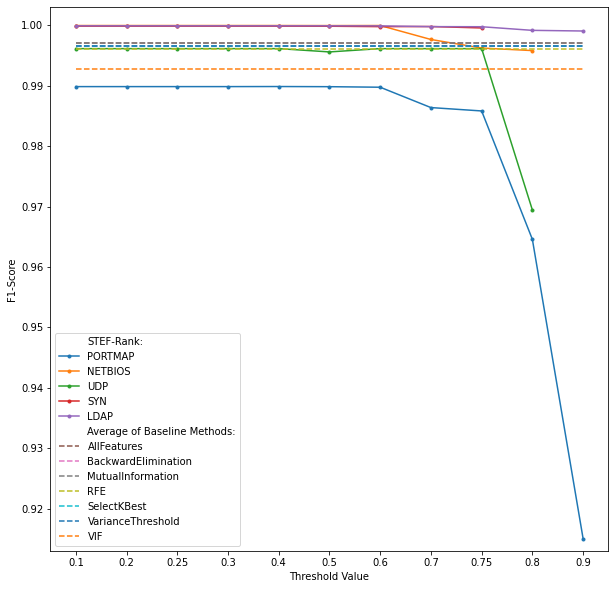

In [30]:
# GRAPH for Different STEF-Rank Thresholds

baseline_methods = ['AllFeatures','BackwardElimination','MutualInformation','RFE','SelectKBest','VarianceThreshold','VIF']
new_methods = ['STEF-Rank_0.1','STEF-Rank_0.2','STEF-Rank_0.25','STEF-Rank_0.3','STEF-Rank_0.4',
               'STEF-Rank_0.5','STEF-Rank_0.6','STEF-Rank_0.7','STEF-Rank_0.75','STEF-Rank_0.8',
              'STEF-Rank_0.9']
thresholds = [method.split("_")[1] for method in new_methods]

portmapF1s = performance_df[performance_df['dataset'] == 'portmap_2018']['test_f1'].tolist()[7:]
netbiosF1s = performance_df[performance_df['dataset'] == 'netbios_2019']['test_f1'].tolist()[7:]
udpF1s = performance_df[performance_df['dataset'] == 'udp_2019']['test_f1'].tolist()[7:]
synF1s = performance_df[performance_df['dataset'] == 'syn_2019']['test_f1'].tolist()[7:]
ldapF1s = performance_df[performance_df['dataset'] == 'ldap_2019']['test_f1'].tolist()[7:]


temp = statistics.mean(performance_df[performance_df['method'] == 'AllFeatures']['test_f1'].tolist())
averageAllFeatures = [temp for elem in thresholds]

temp = statistics.mean(performance_df[performance_df['method'] == 'BackwardElimination']['test_f1'].tolist())
BackwardEliminationFeatures = [temp for elem in thresholds]

temp = statistics.mean(performance_df[performance_df['method'] == 'MutualInformation']['test_f1'].tolist())
MutualInformationFeatures = [temp for elem in thresholds]

temp = statistics.mean(performance_df[performance_df['method'] == 'RFE']['test_f1'].tolist())
RFEFeatures = [temp for elem in thresholds]

temp = statistics.mean(performance_df[performance_df['method'] == 'SelectKBest']['test_f1'].tolist())
SelectKBestFeatures = [temp for elem in thresholds]

temp = statistics.mean(performance_df[performance_df['method'] == 'VarianceThreshold']['test_f1'].tolist())
VarianceThresholdFeatures = [temp for elem in thresholds]

temp = statistics.mean(performance_df[performance_df['method'] == 'VIF']['test_f1'].tolist())
VIFFeatures = [temp for elem in thresholds]
    
plt.figure(figsize=(10,10))

plt.plot([], [], marker=' ', color='white', label="STEF-Rank:")
plt.plot(thresholds, portmapF1s, marker='.', label='PORTMAP')
plt.plot(thresholds, netbiosF1s, marker='.', label='NETBIOS')
plt.plot(thresholds, udpF1s, marker='.', label='UDP')
plt.plot(thresholds, synF1s, marker='.', label='SYN')
plt.plot(thresholds, ldapF1s, marker='.', label='LDAP')
plt.plot([], [], marker=' ', color='white', label="Average of Baseline Methods:")
plt.plot(thresholds, averageAllFeatures, label='AllFeatures', linestyle="--")
plt.plot(thresholds, BackwardEliminationFeatures, label='BackwardElimination', linestyle="--")
plt.plot(thresholds, MutualInformationFeatures, label='MutualInformation', linestyle="--")
plt.plot(thresholds, RFEFeatures, label='RFE', linestyle="--")
plt.plot(thresholds, SelectKBestFeatures, label='SelectKBest', linestyle="--")
plt.plot(thresholds, VarianceThresholdFeatures, label='VarianceThreshold', linestyle="--")
plt.plot(thresholds, VIFFeatures, label='VIF', linestyle="--")


#max and min
plt.ylim(0.913,1.003)
# axis labels
plt.xlabel('Threshold Value')
plt.ylabel('F1-Score')

# show the legend
plt.legend()
# show the plot
plt.savefig("../performance/thresholdvsF1.png")

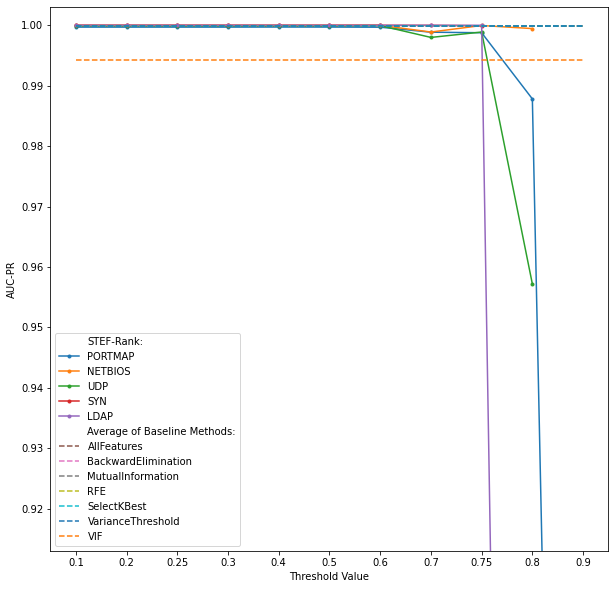

In [33]:
# GRAPH for Different STEF-Rank Thresholds

baseline_methods = ['AllFeatures','BackwardElimination','MutualInformation','RFE','SelectKBest','VarianceThreshold','VIF']
new_methods = ['STEF-Rank_0.1','STEF-Rank_0.2','STEF-Rank_0.25','STEF-Rank_0.3','STEF-Rank_0.4',
               'STEF-Rank_0.5','STEF-Rank_0.6','STEF-Rank_0.7','STEF-Rank_0.75','STEF-Rank_0.8',
              'STEF-Rank_0.9']
thresholds = [method.split("_")[1] for method in new_methods]

portmapF1s = performance_df[performance_df['dataset'] == 'portmap_2018']['auc_pr'].tolist()[7:]
netbiosF1s = performance_df[performance_df['dataset'] == 'netbios_2019']['auc_pr'].tolist()[7:]
udpF1s = performance_df[performance_df['dataset'] == 'udp_2019']['auc_pr'].tolist()[7:]
synF1s = performance_df[performance_df['dataset'] == 'syn_2019']['auc_pr'].tolist()[7:]
ldapF1s = performance_df[performance_df['dataset'] == 'ldap_2019']['auc_pr'].tolist()[7:]


temp = statistics.mean(performance_df[performance_df['method'] == 'AllFeatures']['auc_pr'].tolist())
averageAllFeatures = [temp for elem in thresholds]

temp = statistics.mean(performance_df[performance_df['method'] == 'BackwardElimination']['auc_pr'].tolist())
BackwardEliminationFeatures = [temp for elem in thresholds]

temp = statistics.mean(performance_df[performance_df['method'] == 'MutualInformation']['auc_pr'].tolist())
MutualInformationFeatures = [temp for elem in thresholds]

temp = statistics.mean(performance_df[performance_df['method'] == 'RFE']['auc_pr'].tolist())
RFEFeatures = [temp for elem in thresholds]

temp = statistics.mean(performance_df[performance_df['method'] == 'SelectKBest']['auc_pr'].tolist())
SelectKBestFeatures = [temp for elem in thresholds]

temp = statistics.mean(performance_df[performance_df['method'] == 'VarianceThreshold']['auc_pr'].tolist())
VarianceThresholdFeatures = [temp for elem in thresholds]

temp = statistics.mean(performance_df[performance_df['method'] == 'VIF']['auc_pr'].tolist())
VIFFeatures = [temp for elem in thresholds]
    
plt.figure(figsize=(10,10))

plt.plot([], [], marker=' ', color='white', label="STEF-Rank:")
plt.plot(thresholds, portmapF1s, marker='.', label='PORTMAP')
plt.plot(thresholds, netbiosF1s, marker='.', label='NETBIOS')
plt.plot(thresholds, udpF1s, marker='.', label='UDP')
plt.plot(thresholds, synF1s, marker='.', label='SYN')
plt.plot(thresholds, ldapF1s, marker='.', label='LDAP')
plt.plot([], [], marker=' ', color='white', label="Average of Baseline Methods:")
plt.plot(thresholds, averageAllFeatures, label='AllFeatures', linestyle="--")
plt.plot(thresholds, BackwardEliminationFeatures, label='BackwardElimination', linestyle="--")
plt.plot(thresholds, MutualInformationFeatures, label='MutualInformation', linestyle="--")
plt.plot(thresholds, RFEFeatures, label='RFE', linestyle="--")
plt.plot(thresholds, SelectKBestFeatures, label='SelectKBest', linestyle="--")
plt.plot(thresholds, VarianceThresholdFeatures, label='VarianceThreshold', linestyle="--")
plt.plot(thresholds, VIFFeatures, label='VIF', linestyle="--")


#max and min
plt.ylim(0.913,1.003)
# axis labels
plt.xlabel('Threshold Value')
plt.ylabel('AUC-PR')

# show the legend
plt.legend()
# show the plot
plt.savefig("../performance/thresholdvsAUCPR.png")

# 6. Repeating with Assignment Datasets

In [16]:
a2_ranking = pd.read_csv("../final_ranking/csi5388_assignment2_3_data/assignment2.csv", index_col=0)
a3_ranking = pd.read_csv("../final_ranking/csi5388_assignment2_3_data/assignment3.csv", index_col=0)

In [17]:
a2_train = pd.read_csv("../data/csi5388_assignment2_3_data/assignment2_train.csv", index_col=0)
a3_train = pd.read_csv("../data/csi5388_assignment2_3_data/assignment3_train.csv", index_col=0)

In [18]:
a2_test = pd.read_csv("../data/csi5388_assignment2_3_data/assignment2_test.csv", index_col=0)
a3_test = pd.read_csv("../data/csi5388_assignment2_3_data/assignment3_test.csv", index_col=0)

In [20]:
a2_performance = trainTestModel(a2_train, a2_test, a2_ranking, LogisticRegression, 10, verbose=False)
a2_performance

Training using AllFeatures...
Training using BackwardElimination...
Training using MutualInformation...
Training using RFE...
Training using SelectKBest...
Training using VarianceThreshold...
Training using VIF...
Training using STEF-Rank_0.1...
Training using STEF-Rank_0.2...
Training using STEF-Rank_0.25...
Training using STEF-Rank_0.3...
Training using STEF-Rank_0.4...
Training using STEF-Rank_0.5...
Training using STEF-Rank_0.6...
Training using STEF-Rank_0.7...
Training using STEF-Rank_0.75...
Training using STEF-Rank_0.8...
Training using STEF-Rank_0.9...


,method,num_features,mean_cv_f1,test_f1,auc_pr
0,AllFeatures,42,0.877179,0.716812,0.913272
1,BackwardElimination,25,0.910466,0.770307,0.944220
2,MutualInformation,30,0.876881,0.721832,0.910720
3,RFE,25,0.968008,0.919566,0.988833
4,SelectKBest,25,0.874840,0.716875,0.913150
5,VarianceThreshold,34,0.876923,0.716729,0.913287
6,VIF,30,0.875670,0.716887,0.913201
7,STEF-Rank_0.1,41,0.876877,0.716909,0.913341
8,STEF-Rank_0.2,38,0.876837,0.716909,0.913340
9,STEF-Rank_0.25,38,0.876837,0.716909,0.913340


In [21]:
a3_performance = trainTestModel(a3_train, a3_test, a3_ranking, LogisticRegression, 10, verbose=False)
a3_performance

Training using AllFeatures...
Training using BackwardElimination...
Training using MutualInformation...
Training using RFE...
Training using SelectKBest...
Training using VarianceThreshold...
Training using VIF...
Training using STEF-Rank_0.1...
Training using STEF-Rank_0.2...
Training using STEF-Rank_0.25...
Training using STEF-Rank_0.3...
Training using STEF-Rank_0.4...
Training using STEF-Rank_0.5...
Training using STEF-Rank_0.6...
Training using STEF-Rank_0.7...
Training using STEF-Rank_0.75...
Training using STEF-Rank_0.8...
Training using STEF-Rank_0.9...


,method,num_features,mean_cv_f1,test_f1,auc_pr
0,AllFeatures,10.0,0.810947,0.856911,0.757627
1,BackwardElimination,4.0,0.81103,0.856928,0.757384
2,MutualInformation,6.0,0.807629,0.853246,0.759718
3,RFE,4.0,0.796583,0.840589,0.751052
4,SelectKBest,4.0,0.81103,0.856928,0.760522
5,VarianceThreshold,7.0,0.811024,0.856911,0.757949
6,VIF,10.0,0.810947,0.856911,0.757627
7,STEF-Rank_0.1,10.0,0.810947,0.856911,0.757627
8,STEF-Rank_0.2,10.0,0.810947,0.856911,0.757627
9,STEF-Rank_0.25,10.0,0.810947,0.856911,0.757627


In [23]:
# Combine all performance metrics into one dataframe

a2_performance['dataset'] = 'csi5388_assignment2'
a3_performance['dataset'] = 'csi5388_assignment3'

master_df = pd.concat([a2_performance, a3_performance])

# If you want the new column to be the first column
column_order = ['dataset'] + [col for col in a2_performance.columns if not (col in ['dataset'])]
master_df = master_df[column_order]

In [24]:
master_df.to_csv('../performance/performance_assignment2_3.csv')

In [25]:
baseline_methods = ['AllFeatures','BackwardElimination','MutualInformation','RFE','SelectKBest','VarianceThreshold','VIF']
new_methods = ['STEF-Rank_0.1','STEF-Rank_0.2','STEF-Rank_0.25','STEF-Rank_0.3','STEF-Rank_0.4',
               'STEF-Rank_0.5','STEF-Rank_0.6','STEF-Rank_0.7','STEF-Rank_0.75','STEF-Rank_0.8',
              'STEF-Rank_0.9']

In [26]:
for bm in baseline_methods:
    for nm in new_methods:
        print("____________________________________________________________________________________________")
        
        base_f1s = master_df[master_df['method'] == bm]['test_f1'].tolist()
        new_f1s = master_df[master_df['method'] == nm]['test_f1'].tolist()
        
        base_aucs = master_df[master_df['method'] == bm]['auc_pr'].tolist()
        new_aucs = master_df[master_df['method'] == nm]['auc_pr'].tolist()
        
        base_f1s, new_f1s = zip(*[(x, y) for x, y in zip(base_f1s, new_f1s) if isinstance(x, float) and isinstance(y, float)])
        
        base_aucs, new_aucs = zip(*[(x, y) for x, y in zip(base_aucs, new_aucs) if isinstance(x, float) and isinstance(y, float)])
        
        myTTest(nm,bm,new_f1s,base_f1s,'F1')
        #myWilcoxon(nm,bm,new_f1s,base_f1s,'F1')
        
        myTTest(nm,bm,new_aucs,base_aucs,'AUC-PR')
        #myWilcoxon(nm,bm,new_aucs,base_aucs,'AUC-PR')

____________________________________________________________________________________________
T-statistic: -1.0
P-value: 0.49999999999999956
The difference in the mean F1 cannot be proved to be statistically significant; STEF-Rank_0.1 may not outperform AllFeatures.
T-statistic: -1.0
P-value: 0.49999999999999956
The difference in the mean AUC-PR cannot be proved to be statistically significant; STEF-Rank_0.1 may not outperform AllFeatures.
____________________________________________________________________________________________
T-statistic: -1.0
P-value: 0.49999999999999956
The difference in the mean F1 cannot be proved to be statistically significant; STEF-Rank_0.2 may not outperform AllFeatures.
T-statistic: -1.0
P-value: 0.49999999999999956
The difference in the mean AUC-PR cannot be proved to be statistically significant; STEF-Rank_0.2 may not outperform AllFeatures.
____________________________________________________________________________________________
T-statistic: -1.0
P-v

c:\users\alexa\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\users\alexa\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\users\alexa\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero



P-value: 0.8938070469744741
The difference in the mean F1 cannot be proved to be statistically significant; STEF-Rank_0.6 may not outperform MutualInformation.
T-statistic: -1.2561792915721919
P-value: 0.42802287695331537
The difference in the mean AUC-PR cannot be proved to be statistically significant; STEF-Rank_0.6 may not outperform MutualInformation.
____________________________________________________________________________________________
T-statistic: 0.1308189547052106
P-value: 0.9171883319729355
The difference in the mean F1 cannot be proved to be statistically significant; STEF-Rank_0.7 may not outperform MutualInformation.
T-statistic: -3.462253795455394
P-value: 0.1790029087179899
The difference in the mean AUC-PR cannot be proved to be statistically significant; STEF-Rank_0.7 may not outperform MutualInformation.
____________________________________________________________________________________________
T-statistic: -1.0703169880459633
P-value: 0.4783859265445542
The di

T-statistic: -0.9976860978366023
P-value: 0.5007373907298855
The difference in the mean F1 cannot be proved to be statistically significant; STEF-Rank_0.75 may not outperform SelectKBest.
T-statistic: -1.0152481797781674
P-value: 0.49518317019501873
The difference in the mean AUC-PR cannot be proved to be statistically significant; STEF-Rank_0.75 may not outperform SelectKBest.
____________________________________________________________________________________________
T-statistic: -0.9985949505761023
P-value: 0.5004475554672989
The difference in the mean F1 cannot be proved to be statistically significant; STEF-Rank_0.8 may not outperform SelectKBest.
T-statistic: -1.0111693631435674
P-value: 0.4964644626908829
The difference in the mean AUC-PR cannot be proved to be statistically significant; STEF-Rank_0.8 may not outperform SelectKBest.
____________________________________________________________________________________________
T-statistic: nan
P-value: nan
The difference in the mea